In [2]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
'''
데이터 불러오기
'''
original_data_df = pd.read_csv('./data/original_data.csv')
original_data_df.drop(['location'], axis = 1, inplace = True)
original_data_df.head()

,frontyear,backyear,month,day,temp_avg,temp_min,temp_max
0,19,54,1,18,1.4,-2.2,4.8
1,19,54,1,19,1.5,-1.3,5.8
2,19,54,1,20,4.7,-1.5,10.7
3,19,54,1,21,2.8,0.5,5.5
4,19,54,1,22,-2.1,-6.4,1.6


In [4]:
'''
결측치 확인
'''
original_data_df.isnull().sum()

frontyear    0
backyear     0
month        0
day          0
temp_avg     0
temp_min     1
temp_max     2
dtype: int64

In [5]:
'''
결측치 바로 뒤에 있는 값으로 치환
'''
original_data_df.fillna(method = 'ffill', inplace = True)
original_data_df.isnull().sum()

frontyear    0
backyear     0
month        0
day          0
temp_avg     0
temp_min     0
temp_max     0
dtype: int64

In [6]:
'''
데이터프레임 데이터타입 변환
'''
original_data_df = original_data_df.apply(pd.to_numeric)

In [7]:
'''
계절성 데이터 추가

봄 : 3월 ~ 5월 - 0.05
여름 : 6월 ~ 8월 - 0.25
가을 : 9월 ~ 11월 - 0.42
겨울 : 12월 ~ 2월 - 0.28
'''
season_data = pd.DataFrame(original_data_df['month'])
season_data.columns = ['season']
original_data_df = pd.concat([original_data_df, season_data], axis = 1)
original_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   frontyear  24336 non-null  int64  
 1   backyear   24336 non-null  int64  
 2   month      24336 non-null  int64  
 3   day        24336 non-null  int64  
 4   temp_avg   24336 non-null  float64
 5   temp_min   24336 non-null  float64
 6   temp_max   24336 non-null  float64
 7   season     24336 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 1.5 MB


In [8]:
'''
계절성 데이터 군집화
'''
for season in original_data_df:
    original_data_df.loc[(original_data_df['season'] >= 1) & (original_data_df['season'] < 3), 'season'] = 0.05
    original_data_df.loc[(original_data_df['season'] >= 3) & (original_data_df['season'] < 6), 'season'] = 0.25
    original_data_df.loc[(original_data_df['season'] >= 6) & (original_data_df['season'] < 9), 'season'] = 0.42
    original_data_df.loc[(original_data_df['season'] >= 9) & (original_data_df['season'] < 12), 'season'] = 0.28
    original_data_df.loc[(original_data_df['season'] >= 12), 'season'] = 0.05

In [9]:
'''
데이터프레임 확인
'''
original_data_df.head()

,frontyear,backyear,month,day,temp_avg,temp_min,temp_max,season
0,19,54,1,18,1.4,-2.2,4.8,0.05
1,19,54,1,19,1.5,-1.3,5.8,0.05
2,19,54,1,20,4.7,-1.5,10.7,0.05
3,19,54,1,21,2.8,0.5,5.5,0.05
4,19,54,1,22,-2.1,-6.4,1.6,0.05


In [10]:
'''
데이터 스케일링
'''
max_abs_scaler = MaxAbsScaler()

scaled_data_np = max_abs_scaler.fit_transform(original_data_df)
scaled_data_df = pd.DataFrame(scaled_data_np)
scaled_data_df.columns = ['frontyear', 'backyear', 'month', 'day', 'temp_avg', 'temp_min', 'temp_max', 'season']
scaled_data_df.head()

,frontyear,backyear,month,day,temp_avg,temp_min,temp_max,season
0,0.95,0.545455,0.083333,0.580645,0.041543,-0.072607,0.121212,0.119048
1,0.95,0.545455,0.083333,0.612903,0.044510,-0.042904,0.146465,0.119048
2,0.95,0.545455,0.083333,0.645161,0.139466,-0.049505,0.270202,0.119048
3,0.95,0.545455,0.083333,0.677419,0.083086,0.016502,0.138889,0.119048
4,0.95,0.545455,0.083333,0.709677,-0.062315,-0.211221,0.040404,0.119048


In [11]:
'''
train, test 데이터 분리
'''
train_size = int(len(scaled_data_df) * 0.7)
train_data_df = scaled_data_df[0:train_size].reset_index(drop = True)
validation_data_df = scaled_data_df[:int(len(scaled_data_df) * 0.15):].reset_index(drop = True)
test_data_df = scaled_data_df[-int(len(scaled_data_df) * 0.15):].reset_index(drop = True)

In [12]:
'''
데이터 형태 확인
'''
print("train size:", train_size)
print("result df shape:", scaled_data_df.shape)
print("train df shape:", train_data_df.shape)
print("validation df shape:", validation_data_df.shape)
print("test df shape:", test_data_df.shape)

train size: 17035
result df shape: (24336, 8)
train df shape: (17035, 8)
validation df shape: (3650, 8)
test df shape: (3650, 8)


In [13]:
'''
input, label 데이터 분리
'''
x_train_data_df = train_data_df[['frontyear', 'backyear', 'month', 'day', 'season']]
y_train_data_df = train_data_df[['temp_avg', 'temp_min', 'temp_max']]

x_validation_data_df = validation_data_df[['frontyear', 'backyear', 'month', 'day', 'season']]
y_validation_data_df = validation_data_df[['temp_avg', 'temp_min', 'temp_max']]

x_test_data_df = test_data_df[['frontyear', 'backyear', 'month', 'day', 'season']]
y_test_data_df = test_data_df[['temp_avg', 'temp_min', 'temp_max']]

In [14]:
'''
데이터 형태 확인
'''
print("x train shape:", x_train_data_df.shape)
print("y train shape:", y_train_data_df.shape)
print("x validation shape:", x_validation_data_df.shape)
print("y validation shape:", y_validation_data_df.shape)
print("x test shape", x_test_data_df.shape)
print("y test shape", y_test_data_df.shape)

x train shape: (17035, 5)
y train shape: (17035, 3)
x validation shape: (3650, 5)
y validation shape: (3650, 3)
x test shape (3650, 5)
y test shape (3650, 3)


In [15]:
'''
GPU 사용
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
'''
랜덤시드 고정
'''
torch.manual_seed(777)

In [17]:
'''
하이퍼파라미터

입력 형태: (Batch Size, Sequence Length, Input Dimension)
'''
batch_size = 256 # 64년치 데이터
sequence_length = 1 # 한 개의 batch 당 몇 개의 sequence가 들어있는 개수
input_size = 5
hidden_size = 32
num_layers = 3
output_size = 3 # Trend, Seasonal, Residual
learning_rate = 1e-5
nb_epochs = 400

In [18]:
'''
데이터셋함수
'''
def MakeDataSet(x_data_df, y_data_df):
    x_ts = torch.FloatTensor(np.array(x_data_df))
    y_ts = torch.FloatTensor(np.array(y_data_df))
    dataset_ts = TensorDataset(x_ts, y_ts)

    return dataset_ts

'''
데이터로더
'''
def MakeDataLoader(dataset, batch_size):
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

    return dataloader

In [19]:
'''
데이터셋
'''
train_dataset_ts = MakeDataSet(x_train_data_df, y_train_data_df)
validation_dataset_ts = MakeDataSet(x_validation_data_df, y_validation_data_df)
test_dataset_ts = MakeDataSet(x_test_data_df, y_test_data_df)

'''
데이터로더
'''
train_dataloader = MakeDataLoader(train_dataset_ts, batch_size)
validation_dataloader = MakeDataLoader(validation_dataset_ts, batch_size)
test_dataloader = MakeDataLoader(test_dataset_ts, batch_size)

In [20]:
'''
사용할 데이터 확인
'''
for i, samples in enumerate(test_dataloader):
    x, y = samples
    print("Batch:", i + 1)
    print("Input:",x.shape)
    print("Target:",y.shape)
    if i == 4:
        break

Batch: 1
Input: torch.Size([256, 5])
Target: torch.Size([256, 3])
Batch: 2
Input: torch.Size([256, 5])
Target: torch.Size([256, 3])
Batch: 3
Input: torch.Size([256, 5])
Target: torch.Size([256, 3])
Batch: 4
Input: torch.Size([256, 5])
Target: torch.Size([256, 3])
Batch: 5
Input: torch.Size([256, 5])
Target: torch.Size([256, 3])


In [21]:
'''
model 설계
'''
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = 0.3,
            batch_first = True
        )
        self.fc = nn.Linear(
            hidden_size,
            output_size,
            bias = True
        )

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

In [22]:
'''
model, cost, optimizer
'''
model = Net(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [23]:
'''
모델 테스트
'''
x, y = list(train_dataloader)[0]
x = x.view(-1, sequence_length, input_size).to(device) # RNN input: batch size, sequence length, input size
y = y.to(device)
hypothesis = model(x)
loss = criterion(hypothesis, y)

In [24]:
'''
모델 학습 테스트 데이터 출력
'''
print("X shape:", x.shape)
print("Y shape:", y.shape)
print("Hypothesis:", hypothesis.shape)
print("Optimizer:", optimizer)
print("Loss:", loss)

X shape: torch.Size([256, 1, 5])
Y shape: torch.Size([256, 3])
Hypothesis: torch.Size([256, 3])
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)
Loss: tensor(0.1761, grad_fn=<MseLossBackward>)


In [25]:
'''
학습
'''
trn_loss_list = []
val_loss_list = []
# Train
for epoch in range(nb_epochs):
    # Train Parameters
    trn_loss = 0.0
    for i, samples in enumerate(train_dataloader):
        # Train Data
        x_train, y_train = samples
        x_train = x_train.view(-1, sequence_length, input_size).to(device)
        y_train = y_train.to(device)
        
        # Train
        model.train()
        hypothesis = model(x_train)
        optimizer.zero_grad()
        train_loss = criterion(hypothesis, y_train)
        train_loss.backward()
        optimizer.step()
        
        # Train Loss
        trn_loss += train_loss.item() / len(train_dataloader)
        
    trn_loss_list.append(trn_loss)

    # Evaluation
    with torch.no_grad():
        # Validation Parameters
        val_loss = 0.0
        for ii, validation_samples in enumerate(validation_dataloader):
            # Validation Data
            x_validation, y_validation = validation_samples
            x_validation = x_validation.view(-1, sequence_length, input_size).to(device)
            y_validation = y_validation.to(device)
            
            # Evaluation
            model.eval()
            prediction = model(x_validation)
            validation_loss = criterion(prediction, y_validation)
            
            # Validation Loss
            val_loss += validation_loss.item() / len(validation_dataloader)
            
    val_loss_list.append(val_loss)
    
    print("Epoch: {:3d} | Train Loss: {:.6f} | Val Loss: {:.6f}".format(epoch + 1, trn_loss, val_loss))

torch.save(model, './data/model.pt')

oss: 0.125301 | Val Loss: 0.125259
Epoch:  38 | Train Loss: 0.123925 | Val Loss: 0.122640
Epoch:  39 | Train Loss: 0.122300 | Val Loss: 0.121295
Epoch:  40 | Train Loss: 0.120662 | Val Loss: 0.120027
Epoch:  41 | Train Loss: 0.119371 | Val Loss: 0.118300
Epoch:  42 | Train Loss: 0.117894 | Val Loss: 0.118807
Epoch:  43 | Train Loss: 0.116374 | Val Loss: 0.116491
Epoch:  44 | Train Loss: 0.115107 | Val Loss: 0.115256
Epoch:  45 | Train Loss: 0.113515 | Val Loss: 0.113386
Epoch:  46 | Train Loss: 0.112207 | Val Loss: 0.111584
Epoch:  47 | Train Loss: 0.110878 | Val Loss: 0.110815
Epoch:  48 | Train Loss: 0.109616 | Val Loss: 0.110610
Epoch:  49 | Train Loss: 0.108212 | Val Loss: 0.108590
Epoch:  50 | Train Loss: 0.107182 | Val Loss: 0.106290
Epoch:  51 | Train Loss: 0.105957 | Val Loss: 0.106933
Epoch:  52 | Train Loss: 0.104837 | Val Loss: 0.105890
Epoch:  53 | Train Loss: 0.103713 | Val Loss: 0.105608
Epoch:  54 | Train Loss: 0.102536 | Val Loss: 0.102910
Epoch:  55 | Train Loss: 0.101

In [26]:
'''
train, validation loss 출력
'''
print("train loss list length:", len(trn_loss_list))
print("validation loss list length:", len(val_loss_list))

train loss list length: 400
validation loss list length: 400


In [27]:
'''
결과 데이터 저장
'''
loss_result_df = pd.DataFrame({'Train Loss': trn_loss_list, 'Validation Loss': val_loss_list})
loss_result_df.to_csv('./data/loss_result_df.csv')

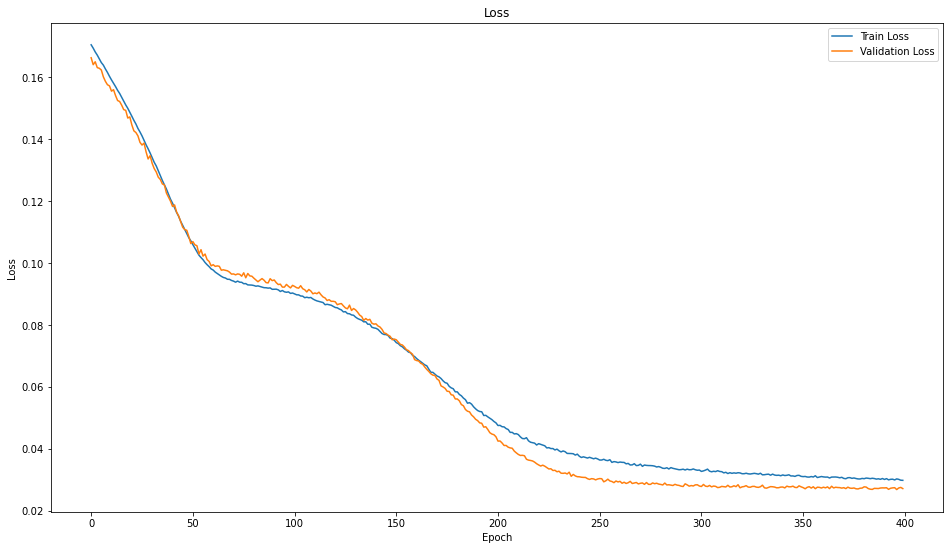

In [28]:
'''
train, validation loss 시각화
'''
plt.figure(figsize = (16, 9))
plt.plot(trn_loss_list, label = 'Train Loss')
plt.plot(val_loss_list, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

In [29]:
'''
평가
'''
original = []
result = []
for i, batch in enumerate(test_dataloader):
    x, y = batch
    x = x.view(-1, sequence_length, input_size).to(device)
    y = y.to(device)
    pred = model(x)
    label = y
    loss = criterion(pred, label)
    original.append(y.tolist())
    result.append(pred.tolist())
    
print(len(result))
print(len(original))

test_original_np = np.array(sum(sum(original, []), []))
test_result_np = np.array(sum(sum(result, []), []))

15
15


In [30]:
'''
데이터프레임 reshape
'''
test_original_df = pd.DataFrame(test_original_np.reshape(-1, 3))
test_result_df = pd.DataFrame(test_result_np.reshape(-1, 3))

print(test_original_df.shape)
print(test_result_df.shape)

(3650, 3)
(3650, 3)


In [31]:
'''
결과 데이터 데이터프레임 결합
'''
reshaped_test_original_df = pd.concat([x_test_data_df, test_original_df], axis = 1)
reshaped_test_result_df = pd.concat([x_test_data_df, test_result_df], axis = 1)

In [32]:
'''
inverse transform 실행 전 컬럼 위치 변경
'''
reshaped_test_original_df.info
reshaped_test_original_df.columns = ['frontyear', 'backyear', 'month', 'day', 'season', 'O_temp_avg', 'O_temp_min', 'O_temp_max']
reshaped_test_result_df.columns = ['frontyear', 'backyear', 'month', 'day', 'season', 'R_temp_avg', 'R_temp_min', 'R_temp_max']

reshaped_test_original_df = reshaped_test_original_df[['frontyear', 'backyear', 'month', 'day', 'O_temp_avg', 'O_temp_min', 'O_temp_max', 'season']]
reshaped_test_result_df = reshaped_test_result_df[['frontyear', 'backyear', 'month', 'day', 'R_temp_avg', 'R_temp_min', 'R_temp_max', 'season']]

print(reshaped_test_original_df.head())
print(reshaped_test_result_df.head())

   frontyear  backyear  month       day  O_temp_avg  O_temp_min  O_temp_max  \
0        1.0   0.10101   0.75  0.225806    0.151335    0.003300    0.234848   
1        1.0   0.10101   0.75  0.258065    0.842730    0.821782    0.843434   
2        1.0   0.10101   0.75  0.290323    0.640950    0.528053    0.674242   
3        1.0   0.10101   0.75  0.322581    0.715134    0.673267    0.747475   
4        1.0   0.10101   0.75  0.354839    0.433234    0.333333    0.502525   

     season  
0  0.666667  
1  0.666667  
2  0.666667  
3  0.666667  
4  0.666667  
   frontyear  backyear  month       day  R_temp_avg  R_temp_min  R_temp_max  \
0        1.0   0.10101   0.75  0.225806    0.012174   -0.119977    0.128771   
1        1.0   0.10101   0.75  0.258065    0.694723    0.648142    0.713927   
2        1.0   0.10101   0.75  0.290323    0.423659    0.333669    0.481334   
3        1.0   0.10101   0.75  0.322581    0.689058    0.641407    0.709119   
4        1.0   0.10101   0.75  0.354839    0.3

In [33]:
'''
예측 데이터 데이터프레임 변환
'''
inversed_test_original_np = max_abs_scaler.inverse_transform(reshaped_test_original_df)
inversed_test_original_df = pd.DataFrame(inversed_test_original_np)

inversed_test_result_np = max_abs_scaler.inverse_transform(reshaped_test_result_df)
inversed_test_result_df = pd.DataFrame(inversed_test_result_np)

In [34]:
'''
데이터프레임 columns 이름 변경
'''
inversed_test_original_df.columns = [['frontyear', 'backyear', 'month', 'day', 'O_temp_avg', 'O_temp_min', 'O_temp_max', 'season']]
inversed_test_result_df.columns = [['frontyear', 'backyear', 'month', 'day', 'P_temp_avg', 'P_temp_min', 'P_temp_max', 'season']]

dropped_test_original_df = inversed_test_original_df[['O_temp_avg', 'O_temp_min', 'O_temp_max']]
dropped_test_result_df = inversed_test_result_df[['P_temp_avg', 'P_temp_min', 'P_temp_max']]

Average temperature


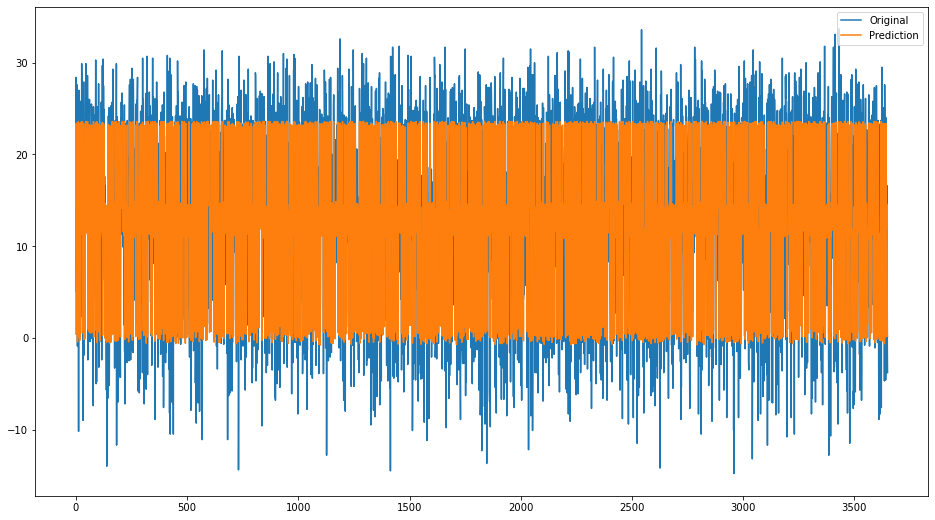

In [35]:
'''
결과 데이터 시각화
'''

# average
print("Average temperature")
plt.figure(figsize = (16, 9))
plt.plot(dropped_test_original_df[['O_temp_avg']], label = 'Original')
plt.plot(dropped_test_result_df[['P_temp_avg']], label = 'Prediction')
plt.legend(loc = 'upper right')
plt.show()

Maximum temperature


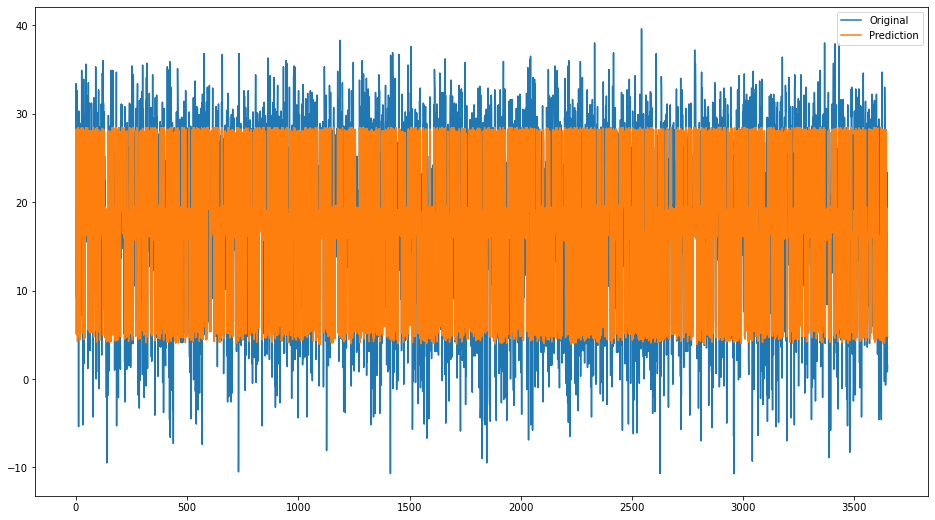

In [36]:
# maximum
print("Maximum temperature")
plt.figure(figsize = (16, 9))
plt.plot(dropped_test_original_df[['O_temp_max']], label = 'Original')
plt.plot(dropped_test_result_df[['P_temp_max']], label = 'Prediction')
plt.legend(loc = 'upper right')
plt.show()

Minimum temperature


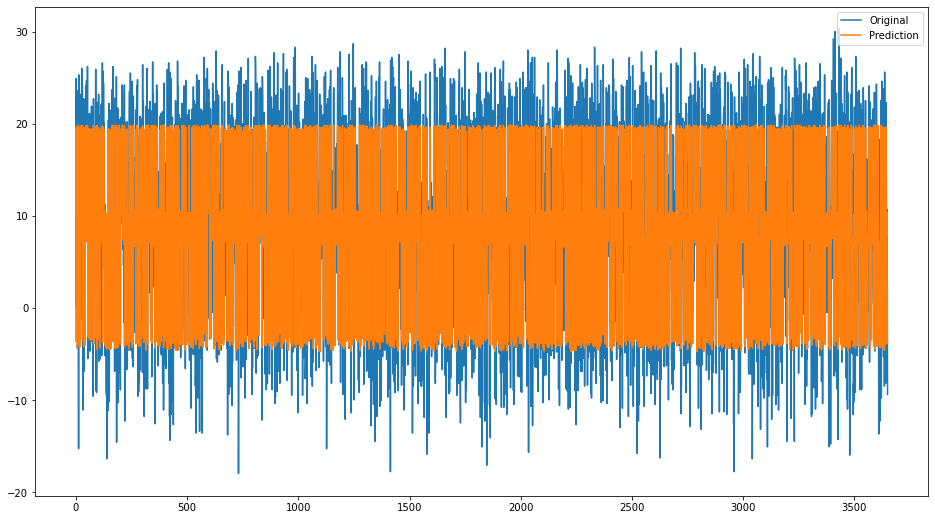

In [37]:
# minimum
print("Minimum temperature")
plt.figure(figsize = (16, 9))
plt.plot(dropped_test_original_df[['O_temp_min']], label = 'Original')
plt.plot(dropped_test_result_df[['P_temp_min']], label = 'Prediction')
plt.legend(loc = 'upper right')
plt.show()

Average temperature


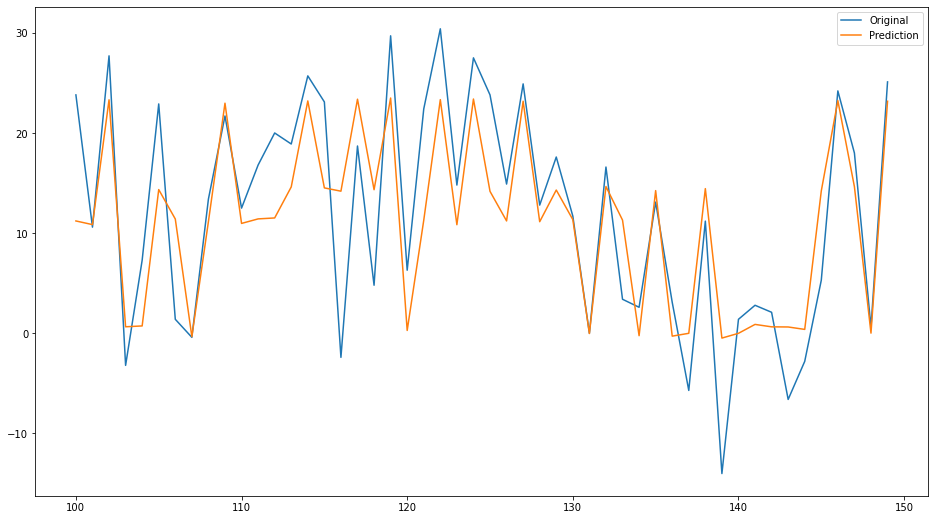

In [38]:
# average[Ni:Nj]
print("Average temperature")
plt.figure(figsize = (16, 9))
plt.plot(dropped_test_original_df[['O_temp_avg']][100:150], label = 'Original')
plt.plot(dropped_test_result_df[['P_temp_avg']][100:150], label = 'Prediction')
plt.legend(loc = 'upper right')
plt.show()